In [3]:
!pip install pandas numpy scikit-learn xgboost statsmodels matplotlib


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")


In [5]:
df = pd.read_csv("shipment_data.csv")

df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df = df.sort_values(['Item', 'Date'])

df.head()


,Item,Class,Backlog,Year,Month,Shipment,Date
0,P001,ModelA,50,2024,1,48,2024-01-01
1,P001,ModelA,48,2024,2,45,2024-02-01
2,P001,ModelA,55,2024,3,60,2024-03-01
3,P001,ModelA,60,2024,4,74,2024-04-01
4,P001,ModelA,58,2024,5,68,2024-05-01


In [6]:
def create_features(data):
    data = data.copy()
    
    for lag in range(1, 7):
        data[f'lag_{lag}'] = data.groupby('Item')['Shipment'].shift(lag)
        
    data['rolling_3'] = data.groupby('Item')['Shipment'].shift(1).rolling(3).mean()
    data['rolling_6'] = data.groupby('Item')['Shipment'].shift(1).rolling(6).mean()
    
    data['month_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['Month'] / 12)
    
    data['Class_Code'] = data['Class'].astype('category').cat.codes
    
    return data

df = create_features(df)
df.dropna(inplace=True)
df.head()


,Item,Class,Backlog,Year,Month,Shipment,Date,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_3,rolling_6,month_sin,month_cos,Class_Code
6,P001,ModelA,65,2024,7,38,2024-07-01,54.0,68.0,74.0,60.0,45.0,48.0,65.333333,58.166667,-0.500000,-8.660254e-01,0
7,P001,ModelA,63,2024,8,22,2024-08-01,38.0,54.0,68.0,74.0,60.0,45.0,53.333333,56.500000,-0.866025,-5.000000e-01,0
8,P001,ModelA,60,2024,9,21,2024-09-01,22.0,38.0,54.0,68.0,74.0,60.0,38.000000,52.666667,-1.000000,-1.836970e-16,0
9,P001,ModelA,58,2024,10,12,2024-10-01,21.0,22.0,38.0,54.0,68.0,74.0,27.000000,46.166667,-0.866025,5.000000e-01,0
10,P001,ModelA,55,2024,11,14,2024-11-01,12.0,21.0,22.0,38.0,54.0,68.0,18.333333,35.833333,-0.500000,8.660254e-01,0


In [7]:
features = [
    'Backlog', 'rolling_3', 'rolling_6',
    'month_sin', 'month_cos', 'Class_Code'
] + [f'lag_{i}' for i in range(1, 7)]

X = df[features]
y = df['Shipment']

split_date = df['Date'].quantile(0.8)

X_train = X[df['Date'] <= split_date]
X_test  = X[df['Date'] > split_date]
y_train = y[df['Date'] <= split_date]
y_test  = y[df['Date'] > split_date]


In [8]:
rf = RandomForestRegressor(random_state=42)

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

tscv = TimeSeriesSplit(n_splits=5)

rf_search = RandomizedSearchCV(
    rf,
    rf_params,
    n_iter=10,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    random_state=42
)

rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_

rf_pred = rf_best.predict(X_test)


In [9]:
xg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

xg_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7]
}

xg_search = RandomizedSearchCV(
    xg,
    xg_params,
    n_iter=10,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    random_state=42
)

xg_search.fit(X_train, y_train)
xg_best = xg_search.best_estimator_

xg_pred = xg_best.predict(X_test)


In [11]:
series = df.groupby('Date')['Shipment'].sum()

arima = ARIMA(series, order=(1,1,1))
arima_fit = arima.fit()

arima_forecast = arima_fit.forecast(steps=len(y_test))


In [12]:
def evaluate(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred))
    }

print("Random Forest:", evaluate(y_test, rf_pred))
print("XGBoost:", evaluate(y_test, xg_pred))


Random Forest: {'MAE': 1.0466666666666669, 'RMSE': np.float64(1.059853239316128)}
XGBoost: {'MAE': 1.925919532775879, 'RMSE': np.float64(2.1137821076411787)}


In [13]:
future = df.iloc[-1:].copy()

predictions = []

for i in range(4):
    rf_p = rf_best.predict(future[features])[0]
    xg_p = xg_best.predict(future[features])[0]
    
    final_pred = (rf_p + xg_p) / 2
    predictions.append(final_pred)
    
    future['lag_6'] = future['lag_5']
    future['lag_5'] = future['lag_4']
    future['lag_4'] = future['lag_3']
    future['lag_3'] = future['lag_2']
    future['lag_2'] = future['lag_1']
    future['lag_1'] = final_pred

months = ['Sep', 'Oct', 'Nov', 'Dec']
forecast_df = pd.DataFrame({'Month': months, 'Predicted Shipment': predictions})
forecast_df


,Month,Predicted Shipment
0,Sep,18.161463
1,Oct,18.363130
2,Nov,18.363130
3,Dec,18.363130


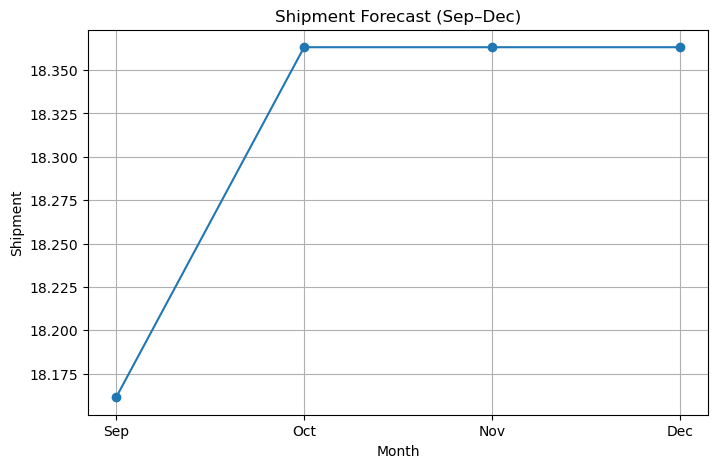

In [14]:
plt.figure(figsize=(8,5))
plt.plot(months, predictions, marker='o')
plt.title("Shipment Forecast (Sep–Dec)")
plt.xlabel("Month")
plt.ylabel("Shipment")
plt.grid()
plt.show()
